<a href="https://colab.research.google.com/github/acbikash13/ManufacturingDefectSystem/blob/main/Automated_Coil_Detection_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Import Required packages


In [ ]:
#import the required packages
!pip install pyod
!pip install scikeras
# Required Packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, normalize
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report, explained_variance_score, f1_score
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import to_categorical
from scikeras.wrappers import KerasClassifier

#Classifying AP4_COils Material Source


##Data Pre-processing

In [ ]:
#import the required datasets
dataFrame = pd.read_csv("export_data_AP4_Defect.csv")


    These are the columns we have in the the AP4_Defects Table. 'CoilId', 'DefectId', 'Class', 'Grade', 'PeriodId', 'PeriodLength','PositionCD', 'PositionRCD', 'PositionMD', 'Side', 'SizeCD', 'SizeMD', 'CameraNo', 'DefectNo', 'MergedTo', 'Confidence', 'RoiX0', 'RoiX1', 'RoiY0', 'RoiY1', 'OriginalClass', 'PP_ID','PostCL', 'MergerPP','OnlineCPP', 'OfflineCPP', 'Rollerid', 'InternalStatus','CL_PROD_CLASS', 'CL_TEST_CLASS', 'AbsPosCD'

In [ ]:

#Research problem 1: We are trying to predict the coil
#data preprocessing for the AP4_Defects
def prepDataFromAP4_Defects(dataFrame):
    #These are the columns with status unknown in the data dictionary. This means we do not know what they mean so we  decided to drop those tables.
    dataFrame.drop(columns=["Confidence","OriginalClass","PP_ID","PostCL","MergerPP","OnlineCPP","OfflineCPP","Rollerid","InternalStatus","CL_PROD_CLASS","CL_TEST_CLASS","AbsPosCD"], inplace=True)
    missing_values = dataFrame.isna().sum()
    print("\n\nThe missing values in the AP4_defects table in combined are: ")
    print(missing_values)
    #drop all the na values
    dataFrame.dropna(inplace=True)
    # Drop duplicate rows
    dataFrame.drop_duplicates(inplace=True)
    print(dataFrame.columns)
    print(dataFrame)
prepDataFromAP4_Defects(dataFrame)

In [ ]:

#outlier detection
def outlier_prepDataFromAP4_Defects(dataFrame):
    #These are all the columns with the numerical values
    numerical_cols = ['Grade', 'PeriodId', 'PeriodLength', 'PositionCD', 'PositionRCD', 'PositionMD', 'SizeCD',
                      'SizeMD', 'CameraNo', 'DefectNo', 'MergedTo', 'RoiX0', 'RoiX1', 'RoiY0', 'RoiY1']
    #get the columns with just the numerical values
    X = dataFrame[numerical_cols]
    # Normalize the data
    X_normalized = normalize(X)
    # Initialize the KNN model
    contamination = 0.0528  #Adjust this value based on your expected outlier ratio
    knn = KNN(contamination=contamination)
    # Fit the KNN model to the normalized data
    knn.fit(X_normalized)
    #joblib.dump(knn,'outlierDetectionForAP4DefectsKNNt.pkl')
    # Get outlier scores and labels
    outlier_scores = knn.decision_scores_
    outlier_labels = knn.labels_
    # Create DataFrame with the required data
    df = pd.DataFrame(X_normalized, columns=numerical_cols)
    df['Outlier Score'] = outlier_scores
    df['Class'] = np.where(outlier_labels == 1, 'Outlier', 'Normal')
    # Identify outlier records
    outlier_records = df[df['Class'] == 'Outlier']
    print(outlier_records)
    #get the index of the rows where the Class feature is 'Outlier'
    outlierIndex = df.index[df['Class'] == 'Outlier'].tolist()
    # Save outlier records to CSV
    # Print outlier records
    print(outlier_records)
    outlier_records.to_csv("KNN_outlier_records_AP4_Defects.csv", index=False)
    # Plot the scatterplot of outlier scores
    plt.figure(figsize=(10, 10))
    plt.scatter(range(len(X)), outlier_scores, s=10, c=outlier_labels, cmap='coolwarm', alpha=0.5)
    plt.title('Scatterplot of Outlier Scores for AP4 with KNN', fontsize=16)
    plt.xlabel('Data Point Index', fontsize=14)
    plt.ylabel('Outlier Score', fontsize=14)
    plt.axhline(knn.threshold_, color='k', linestyle='--', label=f'Threshold = {knn.threshold_:.4f}')
    plt.legend()
    plt.show()


In [ ]:

#ISOLATION FOREST OUTLIER DETECTION
def SecondMethod_outlier_prepDataFromAP4_Defects(dataFrame):
    numerical_cols = ['Grade', 'PeriodId', 'PeriodLength', 'PositionCD', 'PositionRCD', 'PositionMD', 'SizeCD',
                      'SizeMD', 'CameraNo', 'DefectNo', 'MergedTo', 'RoiX0', 'RoiX1', 'RoiY0', 'RoiY1']
    X = dataFrame[numerical_cols]
    # Normalize the data
    X_normalized = normalize(X)
    # Initialize the Isolation Forest model
    isolation_forest = IForest(contamination=0.0528)  # Adjust contamination based on expected outlier ratio
    # Fit the model
    isolation_forest.fit(X_normalized)
    #joblib.dump(isolation_forest,'outlierDetectionForAP4DefectsIsolationForest.pkl')
    # Get outlier scores and labels
    outlier_scores = isolation_forest.decision_function(X_normalized)
    outlier_labels = isolation_forest.labels_
    # Create DataFrame with the required data
    df = pd.DataFrame(X_normalized, columns=numerical_cols)
    df['Outlier Score'] = outlier_scores
    df['Class'] = np.where(outlier_labels == 1, 'Outlier', 'Normal')
    # Identify outlier records
    outlier_records = df[df['Class'] == 'Outlier']
    # Here this line ensures that we only have the values in our Dataframe that are not outliers. We decided to chose this outlier detector compared to the other one after analyzing the results.
    # and just updated the dataframe. Please check the word document file on why we choose this method for outlier detection more as we have mentioned there.
    dataFrame = dataFrame[df['Class'] == 'Normal']
    # Save outlier records to CSV for the AP4 Defects table
    outlier_records.to_csv("Isolation_forest_outlier_records_AP4_Defects.csv", index=False)
    # Print outlier records
    print("The outlier records for the AP4 Defects Table for the Isolation Forest are:\n ")
    print("------------------------------------------------------------------\n")
    print(outlier_records)
    # Plot the scatterplot of outlier scores
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(X)), outlier_scores, s=10, c=outlier_labels, cmap='coolwarm', alpha=0.5)
    plt.title('Scatterplot of Outlier Scores (Isolation Forest) for AP4 Defects Table', fontsize=16)
    plt.xlabel('Data Point Index', fontsize=14)
    plt.ylabel('Outlier Score', fontsize=14)
    plt.axhline(isolation_forest.threshold_, color='k', linestyle='--',
                label=f'Threshold = {isolation_forest.threshold_:.4f}')
    plt.legend()
    plt.show()


          Grade  PeriodId  PeriodLength  PositionCD  PositionRCD  PositionMD  \
54     0.000030  0.000060      0.014152    0.035605     0.002483    0.943771   
62     0.000190 -0.000038      0.000000    0.019861     0.031211    0.982430   
75     0.000038  0.000307      0.018522    0.042412     0.005407    0.887697   
82     0.000145 -0.000029      0.000000    0.008937     0.029888    0.978809   
114    0.000019  0.000322      0.009565    0.000568     0.024132    0.814147   
...         ...       ...           ...         ...          ...         ...   
25427  0.000262  0.000367      0.026024    0.050748     0.001106    0.997191   
25430  0.000064  0.000026      0.000000    0.009649     0.002773    0.923847   
25438  0.000069 -0.000069      0.000000    0.011812     0.095666    0.993543   
25439  0.000595 -0.000119      0.000000    0.073984     0.084263    0.988776   
25481  0.000214  0.002012      0.020845    0.025917     0.041420    0.998257   

         SizeCD    SizeMD  CameraNo  De

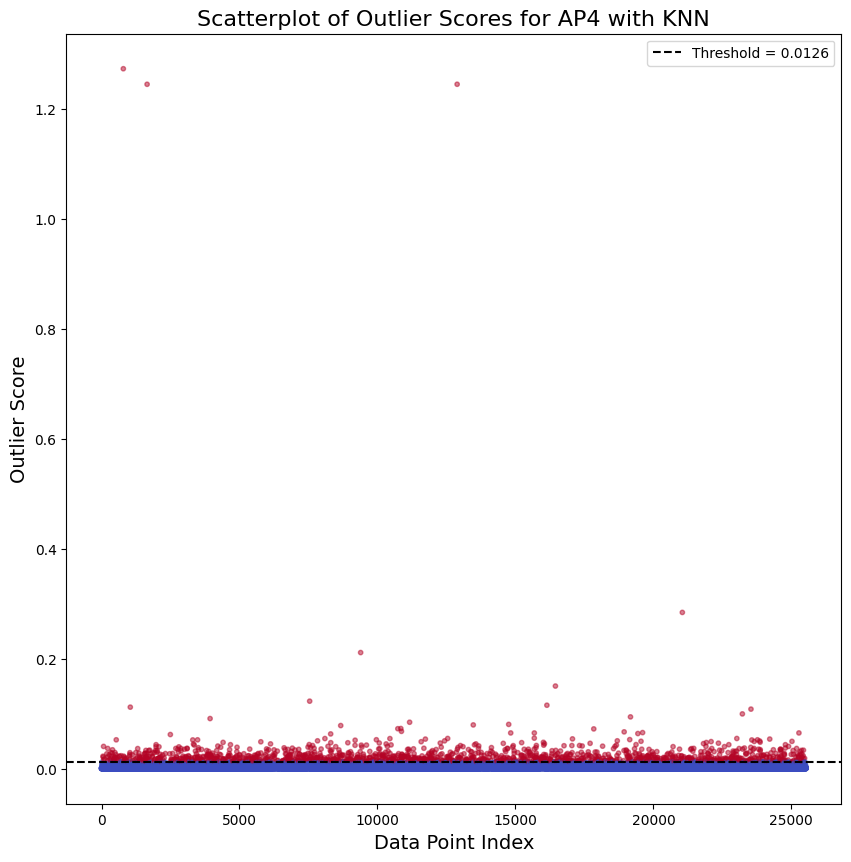

The outlier records for the AP4 Defects Table for the Isolation Forest are:
 
------------------------------------------------------------------

          Grade  PeriodId  PeriodLength  PositionCD  PositionRCD  PositionMD  \
17     0.000041 -0.000041      0.000000    0.046269     0.000894    0.998735   
22     0.000188 -0.000038      0.000000    0.040292     0.008205    0.998777   
54     0.000030  0.000060      0.014152    0.035605     0.002483    0.943771   
62     0.000190 -0.000038      0.000000    0.019861     0.031211    0.982430   
75     0.000038  0.000307      0.018522    0.042412     0.005407    0.887697   
...         ...       ...           ...         ...          ...         ...   
25438  0.000069 -0.000069      0.000000    0.011812     0.095666    0.993543   
25439  0.000595 -0.000119      0.000000    0.073984     0.084263    0.988776   
25458  0.000264 -0.000053      0.000000    0.081299     0.001266    0.996386   
25481  0.000214  0.002012      0.020845    0.025917   

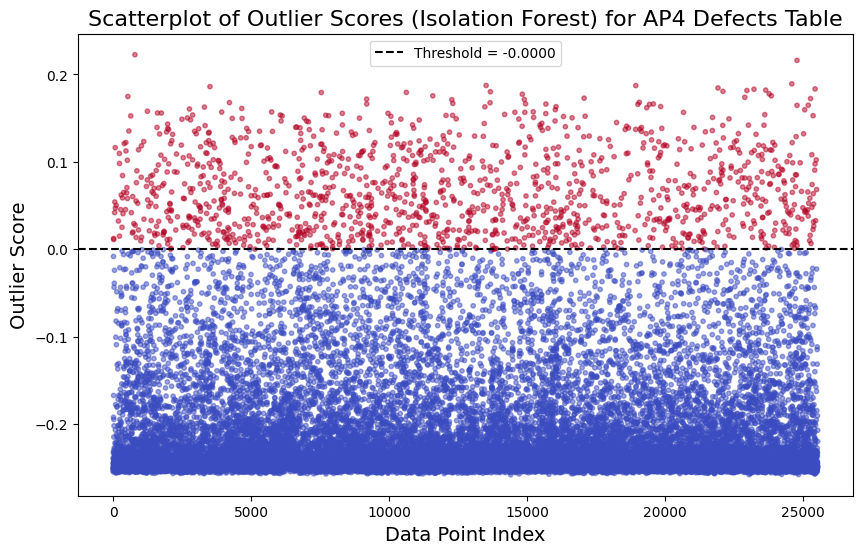

In [ ]:
#used KNN in this outlier detector to drop the values.
outlier_prepDataFromAP4_Defects(dataFrame)
#call the outlier detector from where we have not dropeed the outlier values and then only the other one which we used to drop the values.
SecondMethod_outlier_prepDataFromAP4_Defects(dataFrame)



##Outlier Detection

<Figure size 1200x1200 with 0 Axes>

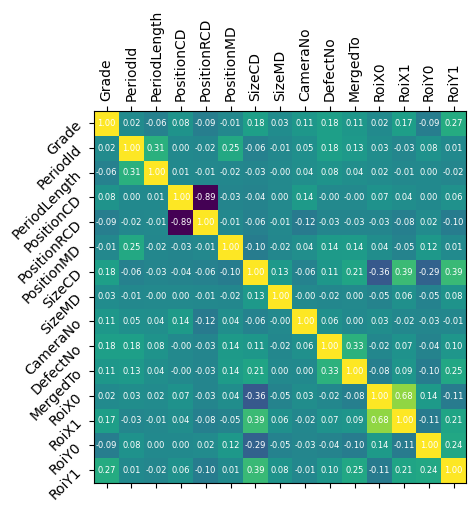

In [ ]:
#this function checks for the collinearity between the features in a dataframe and only keeps the one features that is from among the highly collinear features.
#We just want to have one feature in our dataset if we found collinearity between the features in the AP4 Defects table
def checkForCollinearity(inputDataframe):
#get the numerical features
  numerical_cols = ['Grade', 'PeriodId', 'PeriodLength', 'PositionCD', 'PositionRCD', 'PositionMD', 'SizeCD',
                  'SizeMD', 'CameraNo', 'DefectNo', 'MergedTo', 'RoiX0', 'RoiX1', 'RoiY0', 'RoiY1']
  correlation_matrix = dataFrame[numerical_cols].corr()
  plt.figure(figsize=(12, 12))
  plt.matshow(correlation_matrix, cmap='viridis')
  # Add correlation values
  for i in range(len(correlation_matrix)):
      for j in range(len(correlation_matrix)):
          plt.text(j, i, "{:.2f}".format(correlation_matrix.iloc[i, j]), ha='center', va='center', color='white',  fontsize = 6) # Add column labels
          plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation = 90)
          # Add row labels
          plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation = 45)
  plt.show()
checkForCollinearity(dataFrame)

#PositionRCD and PositionCD are highly collinear, Based on the Collinear Matrix Heatmap. So droping one of the column i.e PositionCD. Our threashold value is greater than 0.5
dataFrame.drop(columns =['PositionCD'], inplace= True)

In [ ]:
dataFrame.columns

##Classification Using DecisionTreeClassifier

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores: with 5 folds [0.57313491 0.51028001 0.40767574 0.48364989 0.56619663]
Mean accuracy: 0.5081874367194601
--------------------------------------------



/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=10.
  warnings.warn(


Cross-validation scores: with 10 folds [0.59710258 0.58927173 0.54737666 0.54855129 0.56286722 0.32236584
 0.40462201 0.56952605 0.57540149 0.57971014]
Mean accuracy: 0.5296795024570722

With different test train ratio:

Accuracy with 20% test size: 0.5911494027804973
after plt fig
After plotting the tree.


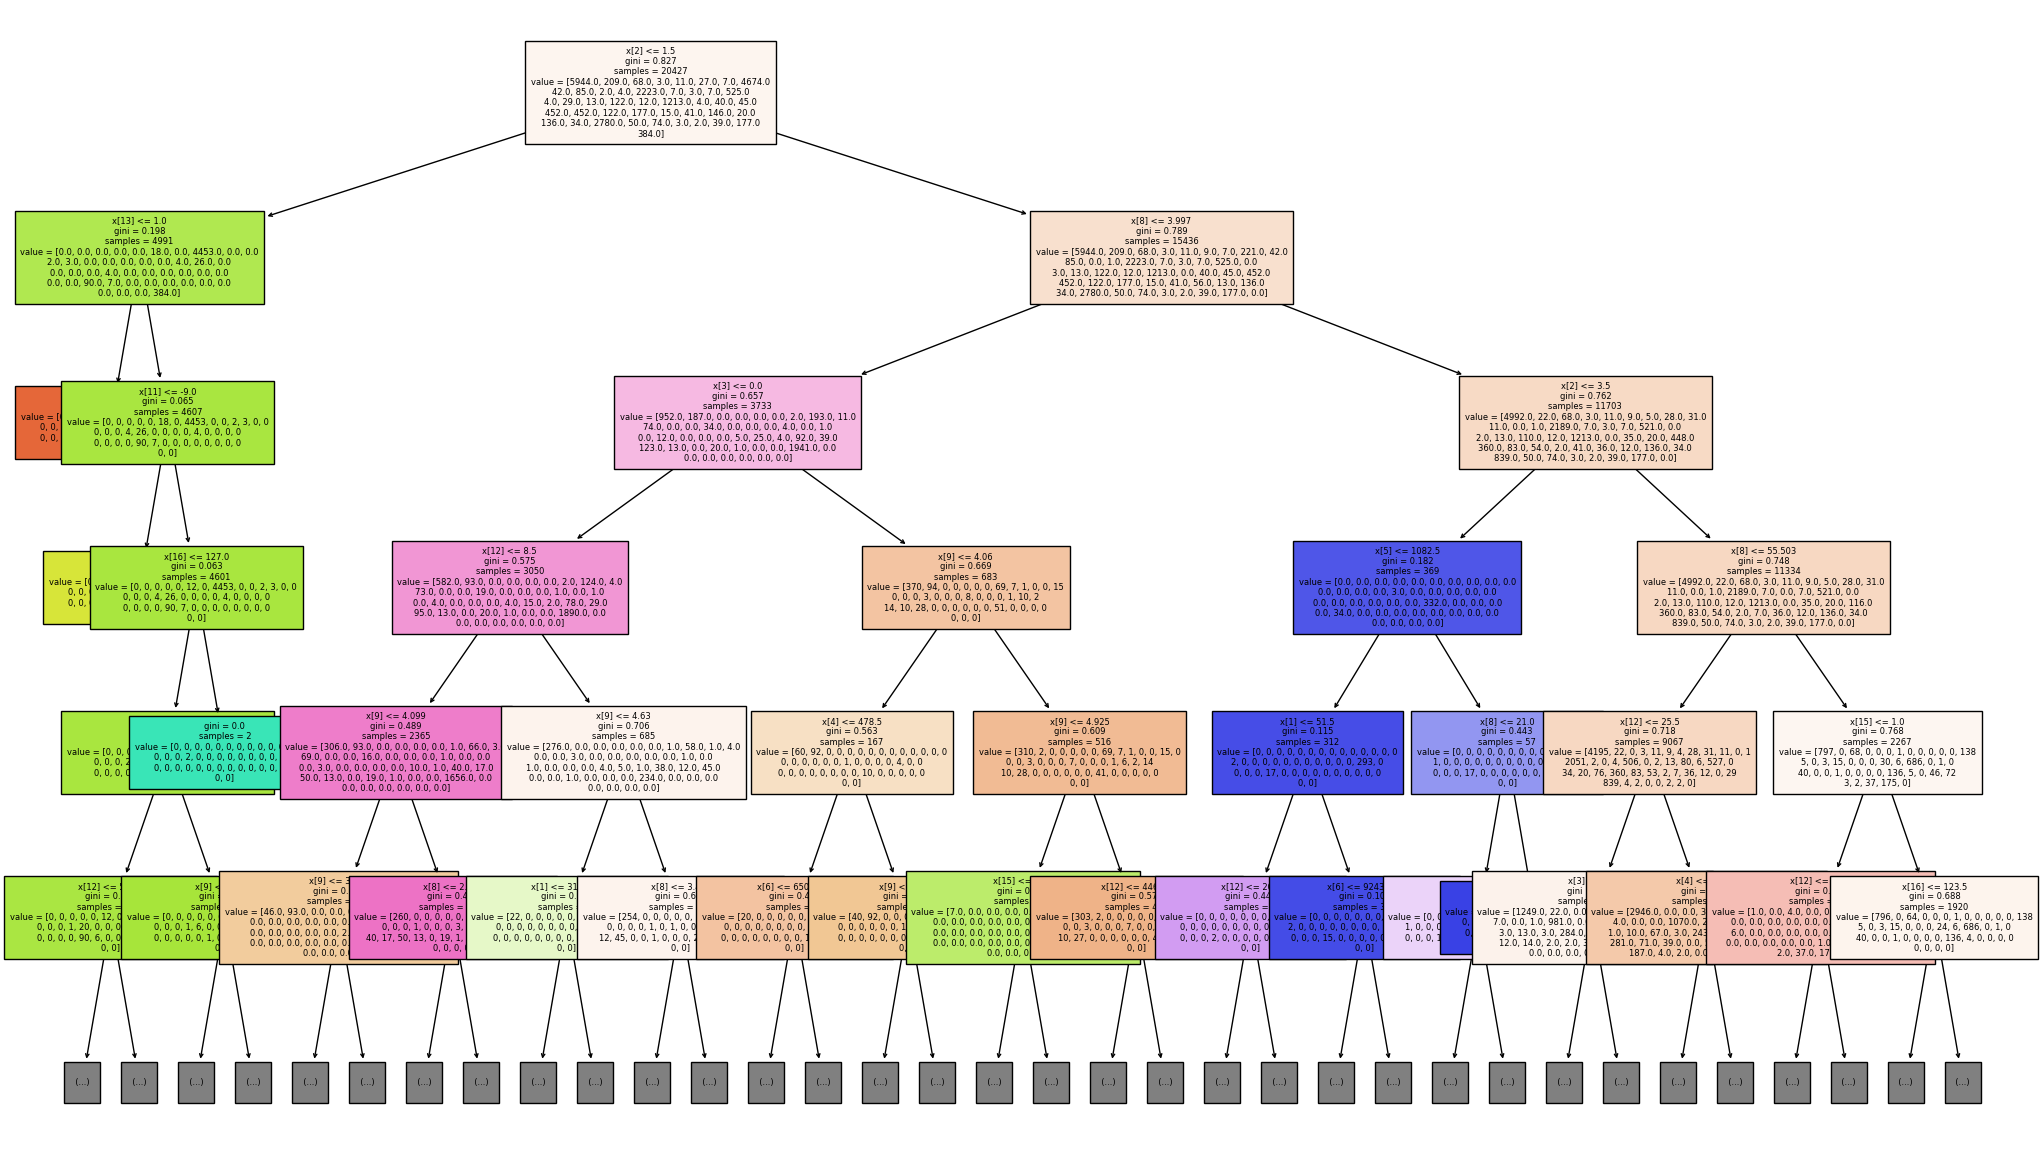


With 40% test size:
 
Accuracy with 40% test size: 0.5827295868415899
Accuracy with 50% test size: 0.5829090624265685


In [ ]:
def decisionTreeClassification(dataFrame):
    #divide the dataset into target and features.
    X = dataFrame.drop(columns = ['Class'],inplace= False)
    #Class is the column we are trying to get
    y = dataFrame['Class']

    decision_tree_model = DecisionTreeClassifier()
    cv_scores = cross_val_score(decision_tree_model, X, y, cv=5)  # cv=5 for 5 folds, cv =10 for 10 folds.
    print("Cross-validation scores: with 5 folds", cv_scores)
    print("Mean accuracy:", cv_scores.mean())
    print("--------------------------------------------\n")
    #for 10 folds
    cv_scores = cross_val_score(decision_tree_model, X, y, cv=10)  # cv=5 for 5 folds, cv =10 for 10 folds.
    print("Cross-validation scores: with 10 folds", cv_scores)
    print("Mean accuracy:", cv_scores.mean())

    print("\nWith different test train ratio:\n")
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    decision_tree_model.fit(X_train, y_train)

    #save the model as a pickle file so that we can use it later without the need to train the model agian
    #joblib.dump(decision_tree_model,"decisionTreeClassifierForAP4Defects.pkl")

    y_pred = decision_tree_model.predict(X_test)
    accuracy_20_percent = accuracy_score(y_test, y_pred)
    print("Accuracy with 20% test size:", accuracy_20_percent)
    # plot the tree for 80:20 trainig test size as this is the standard practice.
    plt.figure(figsize=(25, 15))
    plt.title("Decision Tree Classifier")
    print("after plt fig")
    plot_tree(decision_tree_model, filled=True, max_depth=5, fontsize=6)
    print("After plotting the tree.")
    plt.show()

    #we can now also test on other ratios.
    print("\nWith 40% test size:\n ")
    # Train the model and evaluate with 40% test size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    decision_tree_model.fit(X_train, y_train)
    y_pred = decision_tree_model.predict(X_test)
    accuracy_40_percent = accuracy_score(y_test, y_pred)
    print("Accuracy with 40% test size:", accuracy_40_percent)

    # Train the model and evaluate with 50% test size
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)
    decision_tree_model.fit(X_train, y_train)
    y_pred = decision_tree_model.predict(X_test)
    accuracy_50_percent = accuracy_score(y_test, y_pred)
    print("Accuracy with 50% test size:", accuracy_50_percent)
decisionTreeClassification(dataFrame)

##Using Keras ANN To detect the defect Class



In [ ]:
def ANN_Keras_AP4Defects(dataFrame):
    #divide the dataset into target and features.
    X = dataFrame.drop(columns = ['Class'],inplace= False)
    #Class is the column we are trying to get
    y = dataFrame['Class']

    # Encode target variable
    label_encoder = LabelEncoder()
    y = to_categorical(label_encoder.fit_transform(y))

    # Encode categorical columns
    X = pd.get_dummies(X, drop_first=True)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the Keras model
    def create_model(input_dim):
        model = Sequential()
        model.add(Dense(64, input_dim=input_dim, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(y.shape[1], activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    # Create the KerasClassifier
    classifier = KerasClassifier(build_fn=create_model, input_dim=X_train_scaled.shape[1], epochs=100, batch_size=32, verbose=0)

    # Perform 5-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(classifier, X_train_scaled, y_train, cv=kfold)
    print("Cross-validation scores for 5 folds:", cv_scores)
    print("Average cross-validation score:", cv_scores.mean())
    print("-----------------------------------------------\n")

    # Perform 10-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(classifier, X_train_scaled, y_train, cv=kfold)
    print("Cross-validation scores for 10 folds:", cv_scores)
    print("Average cross-validation score:", cv_scores.mean())
    print("-----------------------------------------------\n")

    # Train the model
    model = create_model(X_train_scaled.shape[1])
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)
    joblib.dump(model,'ANN_Keras_AP4Defects.pkl')
    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    print("Model with 80/20 : Train/Test ratio", test_acc)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the Keras model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    print('Test accuracy for 40:60 test:train:', test_acc)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the Keras model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    print('Test accuracy for 50:50 test:train:', test_acc)

    return model
ANN_Keras_AP4Defects(dataFrame)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


KeyboardInterrupt: 

#Customer Claim Part


##Data Pre-processing and Collinearity Test

In [ ]:
#Problem 2: Customer claim part
print("Lets enter the next research question part of the project")
dataFrameForCustomerTable= pd.read_csv('export_data_customer_claims.csv', encoding='ISO-8859-1')

Lets enter the next research question part of the project


<Figure size 1200x1200 with 0 Axes>

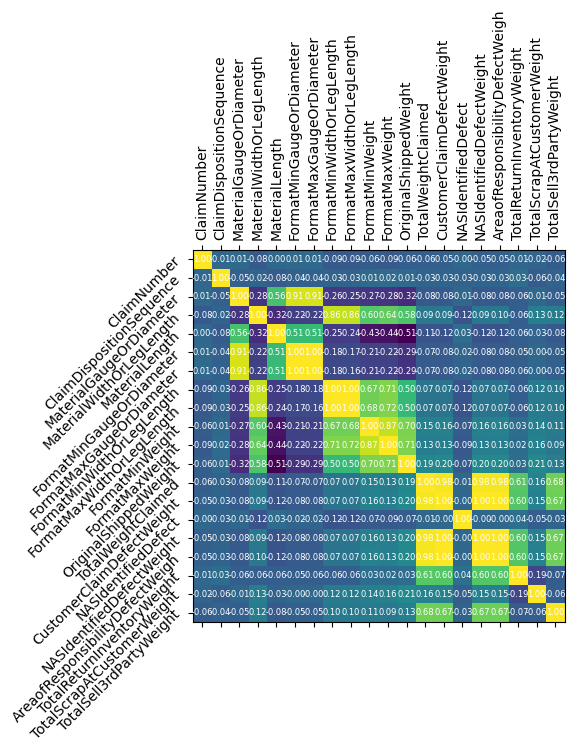

In [ ]:
#This functions cleans the data, checks the collinearuty among the features for the Customer Claims Table.
def prepDataFrom_CustomerClaims(dataFrame):
  #these are the columns we dropped as they did not have any meanings and their descriptoin was unknown
  dataFrame.drop(columns=['ClaimId','ProductIdentification1','ProductIdentification2','Heat','CastDate','CustomerNumber','Format','ClaimDispositionStatus','ClaimCreateDate','QCApprovedDate','ClosedDate','CustomerClaimDefectDesc','TotalCustomerCreditWeight','LastInspectionLine', 'LastInspectionMachine', 'LastInspectedDate',
       'GeneralComment1'], inplace=True)
# Drop missing values
  dataFrame.dropna(inplace=True)
  # Drop duplicate rows
  dataFrame.drop_duplicates(inplace=True)
  #These are the columns with the numerical data type. We are going to check the correleation between these features.
  numerical_cols = ['ClaimNumber', 'ClaimDispositionSequence',
                    'MaterialGaugeOrDiameter', 'MaterialWidthOrLegLength', 'MaterialLength',
                    'FormatMinGaugeOrDiameter', 'FormatMaxGaugeOrDiameter',
                    'FormatMinWidthOrLegLength', 'FormatMaxWidthOrLegLength',
                    'FormatMinWeight', 'FormatMaxWeight', 'OriginalShippedWeight', 'TotalWeightClaimed',
                    'CustomerClaimDefectWeight', 'NASIdentifiedDefect',
                    'NASIdentifiedDefectWeight',
                    'AreaofResponsibilityDefectWeigh',
                    'TotalReturnInventoryWeight', 'TotalScrapAtCustomerWeight',
                    'TotalSell3rdPartyWeight']
  correlation_matrix = dataFrame[numerical_cols].corr()
  plt.figure(figsize=(12, 12))
  plt.matshow(correlation_matrix, cmap='viridis')
  # Add correlation values
  for i in range(len(correlation_matrix)):
      for j in range(len(correlation_matrix)):
          plt.text(j, i, "{:.2f}".format(correlation_matrix.iloc[i, j]), ha='center', va='center', color='white',  fontsize = 6) # Add column labels
          plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation = 90)
          # Add row labels
          plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation = 45)
  plt.show()
   #drop the columns with high collinearity
  #Based on the correlation matrix heat map, these are the columns that were highly collinear with some of the other features. Our threashold collinearity value was 0.5 and we only kept one of the feature
  dataFrame.drop(columns=['FormatMinWidthOrLegLength','FormatMaxGaugeOrDiameter','FormatMinWeight','FormatMaxWeight', 'TotalWeightClaimed','CustomerClaimDefectWeight','NASIdentifiedDefectWeight',
   'AreaofResponsibilityDefectWeigh','TotalReturnInventoryWeight', 'TotalScrapAtCustomerWeight','TotalSell3rdPartyWeight'], inplace=True)
prepDataFrom_CustomerClaims(dataFrameForCustomerTable)


##Outlier Test

In [ ]:

#Outlier detection using the KNN for the Customer Claims table.
def outlierDetectionForCustomerClaims(dataFrameForCustomerTable):
  #Drop missing values
  dataFrameForCustomerTable.dropna(inplace=True)
  # Drop duplicate rows
  dataFrameForCustomerTable.drop_duplicates(inplace=True)
  # Select the relevant numerical columns for outlier detection
  numerical_cols = ['ClaimNumber', 'ClaimDispositionSequence',
                  'MaterialGaugeOrDiameter','MaterialWidthOrLegLength', 'MaterialLength',
                  'OriginalShippedWeight', 'NASIdentifiedDefect']
  X = dataFrameForCustomerTable[numerical_cols]
  # Normalize the data
  X_normalized = normalize(X)
  # Initialize the KNN model
  contamination = 0.0528
  knn = KNN(contamination=contamination)
  # Fit the KNN model to the normalized data
  knn.fit(X_normalized)
  #joblib.dump(knn,'outlierDetectionForCustomerClaimsKNN.pkl')
  # Get outlier scores and labels
  outlier_scores = knn.decision_scores_
  outlier_labels = knn.labels_
  # Create DataFrame with the required data
  df = pd.DataFrame(X_normalized, columns=numerical_cols)
  df['Outlier Score'] = outlier_scores
  df['Class'] = np.where(outlier_labels == 1, 'Outlier', 'Normal')
  # Identify outlier records
  outlier_records = df[df['Class'] == 'Outlier']

   #We are only including the rows that are not outlier. This makes changes in the original DataFrame.
  dataFrameForCustomerTable = dataFrameForCustomerTable[df['Class'] == 'Normal']
  # Save outlier records to CSV
  outlier_records.to_csv("outlier_record_For_Customer_Claims_Using_KNN.csv", index=False)
  # Print outlier records
  print(outlier_records)
  # Plot the scatterplot of outlier scores
  plt.figure(figsize=(10, 6))
  plt.scatter(range(len(X)), outlier_scores, s=10, c=outlier_labels, cmap='coolwarm', alpha=0.5)
  plt.title('Scatterplot of Outlier Scores using KNN for Customer Claim Table', fontsize=14)
  plt.xlabel('Data Point Index', fontsize=14)
  plt.ylabel('Outlier Score', fontsize=14)
  plt.axhline(knn.threshold_, color='k', linestyle='--', label=f'Threshold = {knn.threshold_:.4f}')
  plt.legend()
  plt.show()

In [ ]:
def IsolationForest_outlierDetectionForCustomerClaims(dataFrameForCustomerTable):
    numerical_cols = ['ClaimNumber', 'ClaimDispositionSequence',
                      'MaterialGaugeOrDiameter', 'MaterialWidthOrLegLength', 'MaterialLength',
                      'OriginalShippedWeight', 'NASIdentifiedDefect']

    X = dataFrameForCustomerTable[numerical_cols]
    # Normalize the data
    X_normalized = normalize(X)
    # Initialize the Isolation Forest model
    isolation_forest = IForest(contamination=0.0528)  # Adjust contamination based on expected outlier ratio

    # Fit the model
    isolation_forest.fit(X_normalized)
    #joblib.dump(isolation_forest,'outlierDetectionForCustomerClaimsIsolationForest.pkl')

    # Get outlier scores and labels
    outlier_scores = isolation_forest.decision_function(X_normalized)
    outlier_labels = isolation_forest.labels_
    # Create DataFrame with the required data
    df = pd.DataFrame(X_normalized, columns=numerical_cols)
    df['Outlier Score'] = outlier_scores
    df['Class'] = np.where(outlier_labels == 1, 'Outlier', 'Normal')

    # Identify outlier records
    outlier_records = df[df['Class'] == 'Outlier']
    # Save outlier records to CSV
    outlier_records.to_csv("outlier_record_For_Customer_Claims_Using_Isolation_Forest.csv", index=False)
    # Print outlier records
    print(outlier_records)
    # Plot the scatterplot of outlier scores
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(X)), outlier_scores, s=10, c=outlier_labels, cmap='coolwarm', alpha=0.5)
    plt.title('Scatterplot of Outlier Scores (Isolation Forest) for Customer Claim', fontsize=16)
    plt.xlabel('Data Point Index', fontsize=14)
    plt.ylabel('Outlier Score', fontsize=14)
    plt.axhline(isolation_forest.threshold_, color='k', linestyle='--',
                label=f'Threshold = {isolation_forest.threshold_:.4f}')
    plt.legend()
    plt.show()


      ClaimNumber  ClaimDispositionSequence  MaterialGaugeOrDiameter  \
0        0.998252                  0.000015             5.544367e-06   
73       0.890909                  0.000026             9.054753e-07   
171      0.994069                  0.000015             2.564027e-05   
172      0.994350                  0.000015             2.564713e-05   
189      0.998856                  0.000015             3.295828e-05   
...           ...                       ...                      ...   
4373     0.587103                  0.000008             2.764061e-07   
4396     0.589585                  0.000008             2.815056e-07   
4399     0.847410                  0.000012             4.508299e-07   
4417     0.572973                  0.000008             1.797255e-07   
4422     0.591378                  0.000008             2.540352e-07   

      MaterialWidthOrLegLength  MaterialLength  OriginalShippedWeight  \
0                     0.000887        0.004533               0

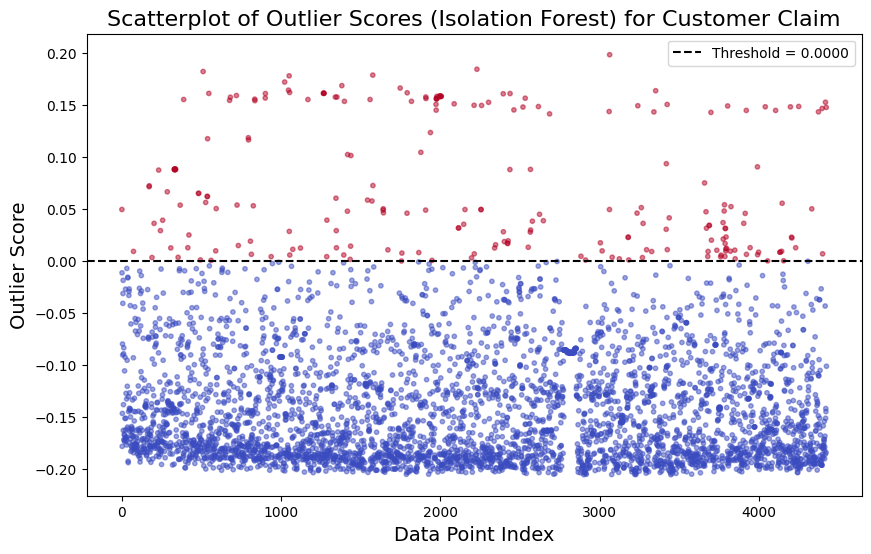

      ClaimNumber  ClaimDispositionSequence  MaterialGaugeOrDiameter  \
0        0.998252                  0.000015             5.544367e-06   
8        0.842611                  0.000012             3.872383e-07   
33       0.975251                  0.000014             3.338965e-07   
110      0.853569                  0.000013             2.913163e-07   
112      0.837389                  0.000012             4.803447e-07   
...           ...                       ...                      ...   
4396     0.589585                  0.000008             2.815056e-07   
4399     0.847410                  0.000012             4.508299e-07   
4415     0.992146                  0.000014             2.570923e-07   
4417     0.572973                  0.000008             1.797255e-07   
4422     0.591378                  0.000008             2.540352e-07   

      MaterialWidthOrLegLength  MaterialLength  OriginalShippedWeight  \
0                     0.000887        0.004533               0

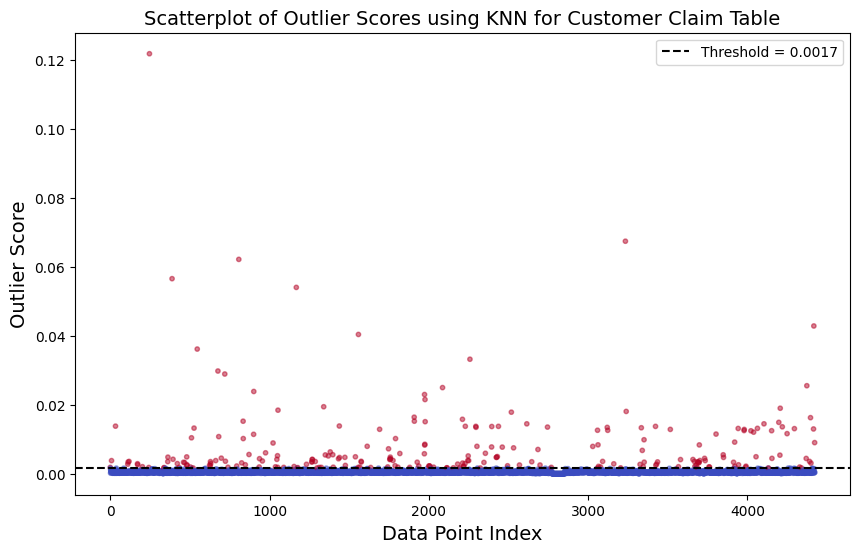

In [ ]:
#call the Isolation forest first as this does not make any change tot he DataFrame and then call the one with KNN. Please see the document for why we choose KNN method for outlier detection
#For the customer claim dataset.
IsolationForest_outlierDetectionForCustomerClaims(dataFrameForCustomerTable)
outlierDetectionForCustomerClaims(dataFrameForCustomerTable)

#build

In [ ]:
dataFrameForCustomerTable.columns

Index(['ClaimSource', 'ClaimNumber', 'ClaimDispositionSequence',
       'BusinessUnit', 'ClaimType', 'MaterialSource', 'ProductType',
       'SteelFamily', 'SteelType', 'SteelGradeASTMAISI', 'Finish',
       'MaterialGaugeOrDiameter', 'MaterialWidthOrLegLength', 'MaterialLength',
       'FormatMinGaugeOrDiameter', 'FormatMaxWidthOrLegLength',
       'OriginalShippedWeight', 'OriginalShipQuality', 'CustomerClaimDefect',
       'NASIdentifiedDefect', 'NASIdentifiedDefectDesc',
       'AreaofResponsibilityDefect', 'AreaofResponsibilityDefectDesc',
       'CustomerDefectOrigin', 'CustomerDefectGroup',
       'CustomerDefectGroupDesc'],
      dtype='object')

##Classify Material Source Id using SVM classifier

In [ ]:
from sklearn.pipeline import make_pipeline

In [ ]:
def classifyMaterialSourceFromInCustomerClaimsTable(dataFrame):
    # Separate the DataFrame into two based on MaterialSource value
    #There was an imbakance between the distribution of Fs and Ls. There were 90% Fs and around 10% Ls.
    # We ran the model on the full dataset and also after balancing the feature distribution in our dataset selection. But the time we got the pretty sames results and decided to go with the balanced dataset.
    df_material_F = dataFrame[dataFrame['MaterialSource'] == 'F']
    df_material_L = dataFrame[dataFrame['MaterialSource'] == 'L']

    # Randomly select around 500 rows for each class
    sampled_material_F = df_material_F.sample(n=500, random_state=42)
    sampled_material_L = df_material_L.sample(n=400, random_state=42)

    # Concatenate the sampled DataFrames
    balanced_df = pd.concat([sampled_material_F, sampled_material_L])

    # Shuffle the rows to mix the samples
    balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate features (X) and target variable (y)
    X = balanced_df.drop(columns=['MaterialSource'])
    y = balanced_df['MaterialSource']

    # Encode categorical variables
    label_encoders = {}
    for column in X.select_dtypes(include='object').columns:
        label_encoders[column] = LabelEncoder()
        X[column] = label_encoders[column].fit_transform(X[column])

    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Create a pipeline with StandardScaler and SVM
    model = make_pipeline(StandardScaler(), SVC(kernel='linear'))
    # Perform cross-validation
    cv_scores = cross_val_score(model, X, y, cv=5)
    print("Cross-validation scores for 5 folds: ", cv_scores)
    print("Average cross-validation score:", cv_scores.mean())

    print("---------------------------------------\n")
    # Perform cross-validation with 10 folds
    cv_scores = cross_val_score(model, X,y, cv=10)
    print("Cross-validation scores with 10 folds:", cv_scores)
    print("Average cross-validation score:", cv_scores.mean())

    print("---------------------------------------\n\n")
    print("With 80:20 train/test size: ")
    # Train the model on the entire training set
    model.fit(X_train, y_train)
    #joblib.dump(model,'classifyMaterialSourceFromInCustomerClaimsTable.pkl')
    # Evaluate the model on the test set
    test_accuracy = model.score(X_test, y_test)
    print("Test set accuracy:", test_accuracy)
    print("---------------------------------------\n")
    print("With 60:40 train/test size: ")
      # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
    # Train the model on the entire training set
    model.fit(X_train, y_train)
    # Evaluate the model on the test set
    test_accuracy = model.score(X_test, y_test)
    print("Test set accuracy:", test_accuracy)

    print("With 40:60 train/test size: ")
    # Split the dataset into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)

    # Train the model on the entire training set
    model.fit(X_train, y_train)
    # Evaluate the model on the test set
    test_accuracy = model.score(X_test, y_test)
    print("Test set accuracy:", test_accuracy)
classifyMaterialSourceFromInCustomerClaimsTable(dataFrameForCustomerTable)


Cross-validation scores for 5 folds:  [1.         1.         0.99444444 0.99444444 0.99444444]
Average cross-validation score: 0.9966666666666667
---------------------------------------

Cross-validation scores with 10 folds: [1.         1.         1.         1.         1.         0.98888889
 0.98888889 0.97777778 0.98888889 0.98888889]
Average cross-validation score: 0.9933333333333334
---------------------------------------


With 80:20 train/test size: 
Test set accuracy: 0.9888888888888889
---------------------------------------

With 60:40 train/test size: 
Test set accuracy: 0.9916666666666667
With 40:60 train/test size: 
Test set accuracy: 0.9907407407407407


## Material Source Id using Keras

In [ ]:
def classifyMaterialSourceFromInCustomerClaimsTable_Keras(dataFrame):
    # Separate the DataFrame into two based on MaterialSource value
    #There was an imbakance between the distribution of Fs and Ls. There were 90% Fs and around 10% Ls.
    # We ran the model on the full dataset and also after balancing the feature distribution in our dataset selection. But the time we got the pretty sames results and decided to go with the balanced dataset.
    df_material_F = dataFrame[dataFrame['MaterialSource'] == 'F'].sample(n=500, random_state=42)
    df_material_L = dataFrame[dataFrame['MaterialSource'] == 'L'].sample(n=400, random_state=42)
    balanced_df = pd.concat([df_material_F, df_material_L]).sample(frac=1, random_state=42).reset_index(drop=True)

    # Separate features (X) and target variable (y)
    X = balanced_df.drop(columns=['MaterialSource'])
    y = balanced_df['MaterialSource']

    # Encode target variable
    label_encoder = LabelEncoder()
    y = to_categorical(label_encoder.fit_transform(y))

    # Encode categorical columns
    X = pd.get_dummies(X, drop_first=True)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the Keras model
    def create_model(input_dim):
        model = Sequential()
        model.add(Dense(64, input_dim=input_dim, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(y.shape[1], activation='softmax'))
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

    # Create the KerasClassifier
    classifier = KerasClassifier(build_fn=create_model, input_dim=X_train_scaled.shape[1], epochs=100, batch_size=32, verbose=0)

    # Perform 5-fold cross-validation
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    cv_scores = cross_val_score(classifier, X_train_scaled, y_train, cv=kfold)
    print("Cross-validation scores for 5 folds:", cv_scores)
    print("Average cross-validation score:", cv_scores.mean())
    print("-----------------------------------------------\n")

    # Perform 10-fold cross-validation
    kfold = KFold(n_splits=10, shuffle=True, random_state=42)
    cv_scores = cross_val_score(classifier, X_train_scaled, y_train, cv=kfold)
    print("Cross-validation scores for 10 folds:", cv_scores)
    print("Average cross-validation score:", cv_scores.mean())
    print("-----------------------------------------------\n")

    # Train the model
    model = create_model(X_train_scaled.shape[1])
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)
    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    print("Model with 80/20 : Train/Test ratio", test_acc)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the Keras model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)
    #joblib.dump(model,"ANNClassifyMaterialSourceForCustomerClaims.pkl")
    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    print('Test accuracy for 40:60 test:train:', test_acc)

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

    # Normalize data
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Define the Keras model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_scaled.shape[1], activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(y.shape[1], activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # Train the model
    model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, validation_data=(X_test_scaled, y_test), verbose=0)

    # Evaluate the model on the test set
    test_loss, test_acc = model.evaluate(X_test_scaled, y_test, verbose=0)
    print('Test accuracy for 50:50 test:train:', test_acc)
classifyMaterialSourceFromInCustomerClaimsTable_Keras(dataFrameForCustomerTable)

/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using 

Cross-validation scores for 5 folds: [0.97916667 0.98611111 0.97916667 0.96527778 0.95833333]
Average cross-validation score: 0.9736111111111111
-----------------------------------------------



/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/scikeras/wrappers.py:925: UserWarning: ``build_fn`` will be renamed to ``model`` in a future release, at which point use of ``build_fn`` will raise an Error instead.
  X, y = self._initialize(X, y)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using 

Cross-validation scores for 10 folds: [0.97222222 0.98611111 1.         1.         0.97222222 0.97222222
 1.         1.         1.         1.        ]
Average cross-validation score: 0.9902777777777778
-----------------------------------------------



/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


NameError: name 'joblib' is not defined

#AP4_Coils Part to Classify Material ID

##Data Preprocessing

In [ ]:

#Part 3: AP4_Coils Part to Classify Material ID from the AP4_coils Table
print("Enter the Research question 3: ")
#create a dataset
dataFrameForMaterialId = pd.read_csv("Steinb_AP4_Coils.csv")

Enter the Research question 3: 


In [ ]:
def prepDataForAP4Coils(dataFrameForMaterialId):
    #These are the columns with status unknown in the data dictionary. This means we do not know what they mean.
    dataFrameForMaterialId.drop(columns=["StartTime","EndTime","ParamSet","Charge","Description","PdiRecvTime","Status","TargetQuality","InternalStatus","Campaign"],inplace = True)
    missing_values = dataFrameForMaterialId.isna().sum()
    dataFrameForMaterialId.dropna(inplace=True)
    # Drop duplicate rows
    dataFrameForMaterialId.drop_duplicates(inplace=True)
prepDataForAP4Coils(dataFrameForMaterialId)


##Collinearity Test

<Figure size 1200x1200 with 0 Axes>

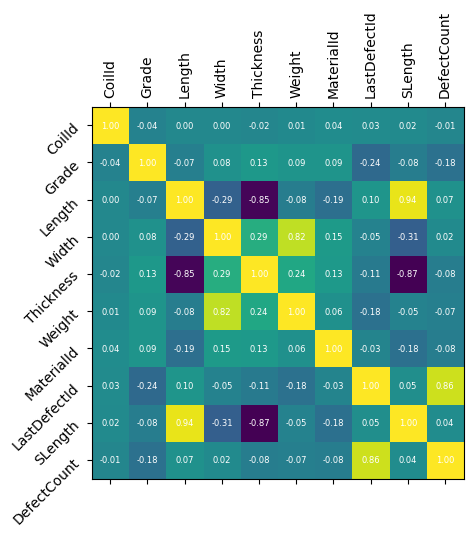

In [ ]:
def collinearityForTheMaterialTypeId(dataFrameForMaterialId):
  numerical_cols = ['CoilId', 'Grade', 'Length', 'Width', 'Thickness', 'Weight',
       'MaterialId', 'LastDefectId', 'SLength', 'DefectCount']
  correlation_matrix = dataFrameForMaterialId[numerical_cols].corr()
  plt.figure(figsize=(12, 12))
  plt.matshow(correlation_matrix, cmap='viridis')
  # Add correlation values
  for i in range(len(correlation_matrix)):
      for j in range(len(correlation_matrix)):
          plt.text(j, i, "{:.2f}".format(correlation_matrix.iloc[i, j]), ha='center', va='center', color='white',  fontsize = 6) # Add column labels
          plt.xticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation = 90)
          # Add row labels
          plt.yticks(range(len(correlation_matrix.columns)), correlation_matrix.columns, rotation = 45)
  plt.show()
collinearityForTheMaterialTypeId(dataFrameForMaterialId)


In [ ]:
#Thickness and Length has -0.85 collineairty score
#Slength and Thickness has -0.87
#dropping Slength and Thickness
dataFrameForMaterialId.drop(columns=['SLength','Thickness'])


##Outlier Test

In [ ]:

#picking the IsolationForest for dropping the values
#picking the IsolationForest for dropping the values
def outlierDetectionForAP4CoilsUsingIsolationForest(dataFrameForMaterialId):
    numerical_cols = ['CoilId', 'Grade', 'Length', 'Width', 'Weight',
       'MaterialId', 'LastDefectId', 'DefectCount']
    X = dataFrameForMaterialId[numerical_cols]
    # Normalize the data

    X_normalized = normalize(X)
    # Initialize the Isolation Forest model
    isolation_forest = IForest(contamination=0.0528)  # Adjust contamination based on expected outlier ratio

    # Fit the model
    isolation_forest.fit(X_normalized)
    #joblib.dump(isolation_forest,'outlierDetectionForAP4CoilsUsingIsolationForest.pkl')

    # Get outlier scores and labels
    outlier_scores = isolation_forest.decision_function(X_normalized)
    outlier_labels = isolation_forest.labels_
    # Create DataFrame with the required data
    df = pd.DataFrame(X_normalized, columns=numerical_cols)
    df['Outlier Score'] = outlier_scores
    df['Class'] = np.where(outlier_labels == 1, 'Outlier', 'Normal')
    # Identify outlier records
    outlier_records = df[df['Class'] == 'Outlier']
    dataFrameForMaterialId = df[df['Class'] == 'Normal']
    outlier_records.to_csv("outlier_record_For_AP4_Coil_Using_Isolation_Forest.csv", index=False)
    # Save outlier records to CSV
    # Print outlier records
    print(outlier_records)
    # Plot the scatterplot of outlier scores
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(X)), outlier_scores, s=10, c=outlier_labels, cmap='coolwarm', alpha=0.5)
    plt.title('Scatterplot of Outlier Scores (Isolation Forest)', fontsize=16)
    plt.xlabel('Data Point Index', fontsize=14)
    plt.ylabel('Outlier Score', fontsize=14)
    plt.axhline(isolation_forest.threshold_, color='k', linestyle='--',
                label=f'Threshold = {isolation_forest.threshold_:.4f}')
    plt.legend()
    plt.show()


In [ ]:
def outlierDetectionForAP4CoilsUsingKNN(dataFrameForMaterialId):
    numerical_cols = ['CoilId', 'Grade', 'Length', 'Width', 'Weight',
                      'MaterialId', 'LastDefectId', 'DefectCount']
    X = dataFrameForMaterialId[numerical_cols]
    print(X.dtypes)
    # Normalize the data
    X_normalized = normalize(X)
    # Initialize the KNN method
    contamination = 0.0528  # Adjust this value based on your expected outlier ratio
    knn = KNN(contamination=contamination)
    # Fit the KNN model to the normalized data
    knn.fit(X_normalized)
    #joblib.dump(knn,'outlierDetectionForAP4CoilsUsingKNN.pkl')
    # Get outlier scores and labels
    outlier_scores = knn.decision_scores_
    outlier_labels = knn.labels_
    # Create DataFrame with the required data
    df = pd.DataFrame(X_normalized, columns=numerical_cols)
    df['Outlier Score'] = outlier_scores
    df['Class'] = np.where(outlier_labels == 1, 'Outlier', 'Normal')

    # Identify outlier records
    outlier_records = df[df['Class'] == 'Outlier']
    print(outlier_records)
    # get the index of the rows where the Class feature is 'Outlier'
    outlierIndex = df.index[df['Class'] == 'Outlier'].tolist()
    # Save outlier records to CSV
    outlier_records.to_csv("outlier_record_For_AP4_Coil_Using_KNN.csv", index=False)
    # Plot the scatterplot of outlier scores
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(X)), outlier_scores, s=10, c=outlier_labels, cmap='coolwarm', alpha=0.5)
    plt.title('Scatterplot of Outlier Scores', fontsize=16)
    plt.xlabel('Data Point Index', fontsize=14)
    plt.ylabel('Outlier Score', fontsize=14)
    plt.axhline(knn.threshold_, color='k', linestyle='--', label=f'Threshold = {knn.threshold_:.4f}')
    plt.legend()
    plt.show()


         CoilId     Grade    Length     Width    Weight  MaterialId  \
11     0.943286  0.000004  0.329604  0.003198  0.039066    0.000372   
12     0.946902  0.000004  0.318978  0.003211  0.039257    0.000373   
14     0.959312 -0.000002  0.276517  0.002610  0.057017    0.000608   
122    0.874498 -0.000002  0.468502  0.002392  0.033193    0.000344   
242    0.911996  0.000004  0.404246  0.003087  0.065862    0.000359   
...         ...       ...       ...       ...       ...         ...   
25638  0.746688 -0.000002  0.638784  0.002535  0.032587    0.000245   
25722  0.891213  0.000004  0.448464  0.003027  0.065439    0.000351   
25724  0.890578  0.000004  0.449649  0.003024  0.065487    0.000351   
25741  0.823085  0.000004  0.565711  0.001675  0.022407    0.000056   
25823  0.873149  0.000004  0.486505  0.002965  0.029835    0.000344   

       LastDefectId  DefectCount  Outlier Score    Class  
11         0.005608     0.002197       0.046884  Outlier  
12         0.008146     0.003

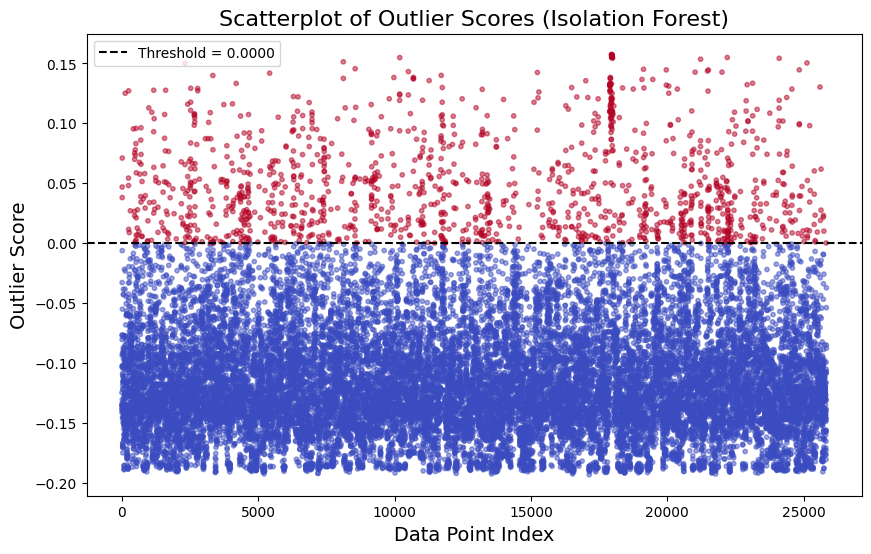

CoilId          int64
Grade           int64
Length          int64
Width           int64
Weight          int64
MaterialId      int64
LastDefectId    int64
DefectCount     int64
dtype: object
         CoilId     Grade    Length     Width    Weight  MaterialId  \
11     0.943286  0.000004  0.329604  0.003198  0.039066    0.000372   
12     0.946902  0.000004  0.318978  0.003211  0.039257    0.000373   
13     0.879501  0.000004  0.471310  0.002982  0.057996    0.000346   
14     0.959312 -0.000002  0.276517  0.002610  0.057017    0.000608   
122    0.874498 -0.000002  0.468502  0.002392  0.033193    0.000344   
...         ...       ...       ...       ...       ...         ...   
25618  0.815560  0.000004  0.576042  0.002795  0.028395    0.000659   
25636  0.822366 -0.000002  0.567253  0.001674  0.022393    0.000056   
25638  0.746688 -0.000002  0.638784  0.002535  0.032587    0.000245   
25723  0.883613  0.000004  0.464622  0.003003  0.057321    0.000348   
25741  0.823085  0.000004  0.

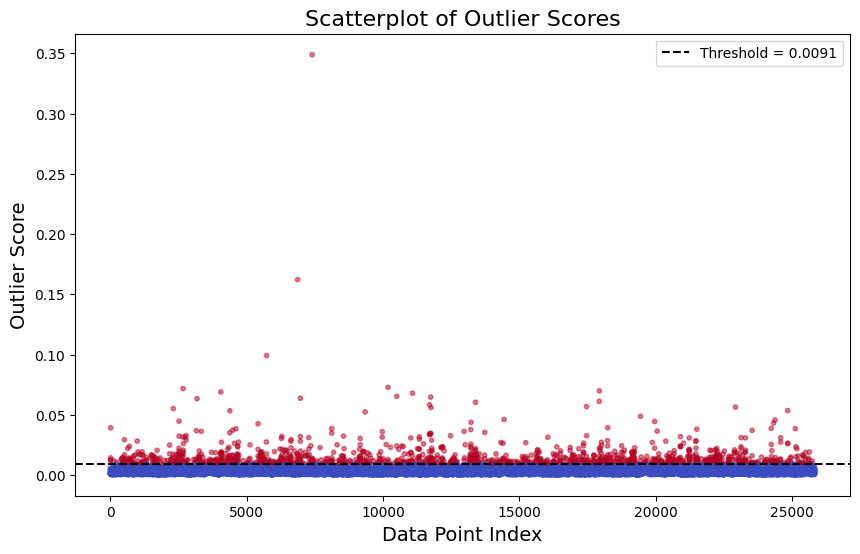

In [ ]:
outlierDetectionForAP4CoilsUsingIsolationForest(dataFrameForMaterialId)
#use this method to drop the outliers.
outlierDetectionForAP4CoilsUsingKNN(dataFrameForMaterialId)
#model

In [ ]:
dataFrameForMaterialId.columns

##Classify Material Type Id with MLP Classifier

In [ ]:
#model
def predictTheMaterialTypeId(dataFrameForMaterialId):
  X = dataFrameForMaterialId.drop(columns=["MaterialId","BdeCoilId"])
  y = dataFrameForMaterialId["MaterialId"]
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  # Create an MLPClassifier
  mlp = MLPClassifier(activation='logistic', solver='adam', random_state=42)
  # Perform k-fold cross-validation
  cv_scores = cross_val_score(mlp, X, y, cv=5)  # cv=5 for 5 folds, you can adjust this as needed
  # Print the cross-validation scores
  print("Cross-validation scores for 5 folds:", cv_scores)
  print("Average cross-validation score:", cv_scores.mean())
  print("-----------------------------------------------\n\n")
  cv_scores = cross_val_score(mlp, X, y, cv=10)  # cv=5 for 5 folds, you can adjust this as needed
  # Print the cross-validation scores
  print("Cross-validation scores for 10 folds:", cv_scores)
  print("Average cross-validation score:", cv_scores.mean())
  print("Model with 80/20 : Train/Test ratio")
  # Train the classifier
  mlp.fit(X_train_scaled, y_train)
  #joblib.dump(mlp,'predictTheMaterialTypeIdForAP4Coils.pkl')
  # Make predictions on the test set
  y_pred = mlp.predict(X_test_scaled)
  # Evaluate the performance of the classifier
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy)
  print("-----------------------------------------------\n\n")
  print("Model with 60/40 Train/Test ration")
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  # Train the classifier
  mlp.fit(X_train_scaled, y_train)
  # Make predictions on the test set
  y_pred = mlp.predict(X_test_scaled)
  # Evaluate the performance of the classifier
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy)
  print("-----------------------------------------------\n\n")
  print("Model with 40/60 Train/Test ration")
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.6, random_state=42)
  scaler = StandardScaler()
  X_train_scaled = scaler.fit_transform(X_train)
  X_test_scaled = scaler.transform(X_test)
  # Train the classifier
  mlp.fit(X_train_scaled, y_train)
  # Make predictions on the test set
  y_pred = mlp.predict(X_test_scaled)
  # Evaluate the performance of the classifier
  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy:", accuracy)
predictTheMaterialTypeId(dataFrameForMaterialId)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(


Cross-validation scores for 5 folds: [0.25140314 0.25546739 0.25933811 0.23108187 0.26049932]
Average cross-validation score: 0.25155796400232244
-----------------------------------------------




/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(


Cross-validation scores for 10 folds: [0.22020124 0.2372291  0.2248452  0.26393189 0.26083591 0.23809524
 0.25319396 0.25783972 0.26442122 0.23848238]
Average cross-validation score: 0.2459075863978454
Model with 80/20 : Train/Test ratio


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.5438358815560287
-----------------------------------------------


Model with 60/40 Train/Test ration


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.5302883684923553
-----------------------------------------------


Model with 40/60 Train/Test ration
Accuracy: 0.4901619250370944


/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


#Research Question 4: Number of Defects on a coil

##Data Preprocessing

In [ ]:
print("\n\nResearch Question part 4 solution:\n")
#read the merged dataset. The  file in the getTheDataFromTheDatabase has the code to get the merged dataset.
df = pd.read_csv("merge_out.csv")



Research Question part 4 solution:



In [ ]:
df = df.drop(
    columns=["StartTime", "EndTime", "ParamSet", "Campaign", "Charge", "Status", "PdiRecvTime", "InternalStatus",
             "InternalStatus.1", "BdeCoilId", "Description", "LastDefectId", "OriginalClass", "PP_ID", "PostCL",
             "MergerPP", "OnlineCPP", "OfflineCPP", "Rollerid", "InternalStatus", "CL_PROD_CLASS", "CL_TEST_CLASS"])

df['MaterialId'] = df['MaterialId'].astype('category')
df['DefectId'] = df['DefectId'].astype('category')
df['Grade'] = df['Grade'].astype('category')


In [ ]:
# Prepare data for training the regression tree model
X = df.drop(columns=['CoilId', 'DefectCount'])  # Features
y = df['DefectCount']  # Target variable

In [ ]:

from sklearn.tree import DecisionTreeRegressor

##Model Training with Test/ Train

In [ ]:
# print(df.dtypes)
#use the 20 percent test, 40 percent test and
for split_size in [0.2, 0.4, 0.5]:
    print("Testing DecisionTreeRegressor on Question 5 using train test split")
    print('Training Set Size: ' + str(split_size))
    # Split the data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=42)

    # Train the Decision Tree Regression model
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)
    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)
    print("R-squared:", r2)
    # Calculate Root Mean Squared Error (RMSE) and explained variance
    rmse = np.sqrt(mse)
    explained_var = explained_variance_score(y_test, y_pred)
    print("Root Mean Squared Error:", rmse)
    print("Explained Variance:", explained_var)
    print()
    print("\n")

Testing DecisionTreeRegressor on Question 5 using train test split
Training Set Size: 0.2
Mean Squared Error: 2394034.49015444
R-squared: 0.8040624442065502
Root Mean Squared Error: 1547.2667805373578
Explained Variance: 0.8043192541465408



Testing DecisionTreeRegressor on Question 5 using train test split
Training Set Size: 0.4
Mean Squared Error: 2587785.2873552125
R-squared: 0.7784249067910767
Root Mean Squared Error: 1608.659469047198
Explained Variance: 0.7784403032730149



Testing DecisionTreeRegressor on Question 5 using train test split
Training Set Size: 0.5
Mean Squared Error: 3002799.1610810813
R-squared: 0.7470855412494347
Root Mean Squared Error: 1732.8586673705047
Explained Variance: 0.7471339719282399





##Cross Validation

In [ ]:

# Perform 5-fold and 10-fold cross-validation
for fold in [5, 10]:
    print("Testing DecisionTreeRegressor on Question 5 using {}-fold cross-validation".format(fold))
    kf = KFold(n_splits=fold, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X, y, cv=kf, scoring='neg_mean_squared_error')
    # Convert negative MSE scores to positive RMSE scores
    cv_rmse_scores = np.sqrt(-cv_scores)

    # Calculate mean RMSE and display cross-validation results
    print("Mean RMSE ({}-fold CV): {:.4f}".format(fold, cv_rmse_scores.mean()))
    print("Cross-Validation RMSE Scores:", cv_rmse_scores)
    print("\n")


Testing DecisionTreeRegressor on Question 5 using 5-fold cross-validation
Mean RMSE (5-fold CV): 1633.9197
Cross-Validation RMSE Scores: [1547.26678054 1617.76809956 1807.94893099 1689.65468486 1506.96010237]


Testing DecisionTreeRegressor on Question 5 using 10-fold cross-validation
Mean RMSE (10-fold CV): 1640.0804
Cross-Validation RMSE Scores: [1467.96903313 1484.36008976 1493.09451092 1679.65170353 1817.98756595
 1652.16793064 1580.79681425 1985.93340658 1669.45365754 1569.38903046]




#Research Question 5: Classify the grade of the steel

In [ ]:

# Plot histogram for the 'Grade' column
# Calculate the threshold for column deletion (10% of total rows)
threshold = len(df) * 0.1
# Drop columns with 10% or more NaN values
df_cleaned2 = df.dropna(axis=1, thresh=threshold)

# Drop rows with any remaining NaN values
df_cleaned2 = df_cleaned2.dropna()

# Display information about the cleaned DataFrame
print("Original DataFrame shape:", df.shape)
print("Cleaned DataFrame shape (after dropping columns and rows with NaNs):", df_cleaned2.shape)

X2 = df_cleaned2.drop(columns=['CoilId', 'DefectCount'])  # Features
y2 = df_cleaned2['DefectCount']  # Target variable

# Now we use different model, the Neural Network Regressor
for split_size in [0.2, 0.4, 0.5]:
    print("Testing MLPRegressor on Question 5 using train test split")
    print('Training Set Size: ' + str(split_size))

    # Split the data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X2, y2, test_size=split_size, random_state=42)

    # Scale the features (important for neural networks)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        # Initialize and train the MLP Regressor model
        model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs', random_state=42)
        model.fit(X_train_scaled, y_train)

        # Evaluate the model on the test set
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        print("Mean Squared Error:", mse)

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        print("R-squared:", r2)

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mse)
        print("Root Mean Squared Error:", rmse)
        print("\n")


Original DataFrame shape: (25899, 32)
Cleaned DataFrame shape (after dropping columns and rows with NaNs): (25723, 32)
Testing MLPRegressor on Question 5 using train test split
Training Set Size: 0.2
Mean Squared Error: 2688018.6376452977
R-squared: 0.7712833016765209
Root Mean Squared Error: 1639.5178064434974


Testing MLPRegressor on Question 5 using train test split
Training Set Size: 0.4
Mean Squared Error: 1961983.0604812766
R-squared: 0.826444080164292
Root Mean Squared Error: 1400.7080568345698


Testing MLPRegressor on Question 5 using train test split
Training Set Size: 0.5
Mean Squared Error: 2011366.2781191862
R-squared: 0.8267898135138119
Root Mean Squared Error: 1418.2264551612293




##Cross Fold Validation

In [ ]:

# Perform 5-fold and 10-fold cross-validation
for fold in [5, 10]:
    print("Testing MLPRegressor on Question 5 using {}-fold cross-validation".format(fold))
    kf = KFold(n_splits=fold, shuffle=True, random_state=42)

    # Scale the features for cross-validation
    X_scaled = scaler.fit_transform(X2)

    # Initialize the MLP Regressor model
    model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs', random_state=42)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        # Perform cross-validation and evaluate with RMSE
        cv_scores = cross_val_score(model, X_scaled, y2, cv=kf, scoring='neg_mean_squared_error')
        cv_rmse_scores = np.sqrt(-cv_scores)

        # Calculate mean RMSE and display cross-validation results
        print("Mean RMSE ({}-fold CV): {:.4f}".format(fold, cv_rmse_scores.mean()))
        print("Cross-Validation RMSE Scores:", cv_rmse_scores)
        print("\n")

print("Running Question 6 Model")
print("Predicting Steel Grade - ")



Testing MLPRegressor on Question 5 using 5-fold cross-validation
Mean RMSE (5-fold CV): 1440.5828
Cross-Validation RMSE Scores: [1389.31833388 1227.62607675 1222.14727494 1189.85306501 2173.96940829]


Testing MLPRegressor on Question 5 using 10-fold cross-validation
Mean RMSE (10-fold CV): 1440.2568
Cross-Validation RMSE Scores: [1366.54908607 1440.02767765 1256.69414898 1201.04197281 1224.58636034
 1098.9902977  1214.92123261 1106.34686856 1308.46312938 3184.94755515]


Running Question 6 Model
Predicting Steel Grade - 


In [ ]:
# Define a function to apply to each row based on 'Grade' value
def map_grade_to_binary(grade):
    if grade == 2:
        return 1
    elif grade == -1:
        return 0
    else:
        return None  # Handle other cases if needed


# Apply the function to create a new column 'NewColumn'
df['GradeClass'] = df['Grade'].apply(lambda x: map_grade_to_binary(x))

# Calculate the threshold for column deletion (10% of total rows)
threshold = len(df) * 0.1

# Drop columns with 10% or more NaN values
df_cleaned = df.dropna(axis=1, thresh=threshold)

# Drop rows with any remaining NaN values
df_cleaned = df_cleaned.dropna()

# Display information about the cleaned DataFrame
print("Original DataFrame shape:", df.shape)
print("Cleaned DataFrame shape (after dropping columns and rows with NaNs):", df_cleaned.shape)

# Save the cleaned DataFrame to a new CSV file

# Prepare the feature (X) and target (y) variables
X = df_cleaned.drop(columns=['GradeClass'])  # Features
y = df_cleaned['GradeClass']  # Target variable

Original DataFrame shape: (25899, 33)
Cleaned DataFrame shape (after dropping columns and rows with NaNs): (25723, 33)


In [ ]:

for split_size in [0.2, 0.4, 0.5]:
    print("Testing KNN on Question 6 using train test split")
    print('Training Set Size: ' + str(split_size))
    # Split the data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=42)

    # Initialize the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=5)  # You can adjust the number of neighbors (k) as needed

    # Train the KNN classifier
    knn.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = knn.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)

    # Display classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

Testing KNN on Question 6 using train test split
Training Set Size: 0.2
Accuracy: 0.7399416909620992
F1 Score: 0.8401051625239006
Classification Report:
              precision    recall  f1-score   support

           0       0.48      0.22      0.30      1310
           1       0.78      0.92      0.84      3835

    accuracy                           0.74      5145
   macro avg       0.63      0.57      0.57      5145
weighted avg       0.70      0.74      0.70      5145

Testing KNN on Question 6 using train test split
Training Set Size: 0.4
Accuracy: 0.7377065111758989
F1 Score: 0.8392591269132273
Classification Report:
              precision    recall  f1-score   support

           0       0.44      0.21      0.29      2559
           1       0.78      0.91      0.84      7731

    accuracy                           0.74     10290
   macro avg       0.61      0.56      0.56     10290
weighted avg       0.69      0.74      0.70     10290

Testing KNN on Question 6 using train te

In [ ]:

for fold in [5, 10]:
    print("Testing KNN for question 6 using {}-fold cross-validation".format(fold))
    kf = KFold(n_splits=fold, shuffle=True, random_state=42)
    cv_scores = cross_val_score(knn, X, y, cv=kf, scoring='accuracy')
    cv_f1_scores = cross_val_score(knn, X, y, cv=kf, scoring='f1')
    mean_f1 = cv_f1_scores.mean()

    print("Mean Accuracy ({}-fold CV): {:.4f}".format(fold, cv_scores.mean()))
    print("Mean F1 Score ({}-fold CV): {:.4f}".format(fold, mean_f1))
    print("Cross-Validation Scores:", cv_scores)
    print("\n")


Testing KNN for question 6 using 5-fold cross-validation
Mean Accuracy (5-fold CV): 0.7377
Mean F1 Score (5-fold CV): 0.8382
Cross-Validation Scores: [0.73994169 0.74577259 0.73158406 0.7336703  0.73736392]


Testing KNN for question 6 using 10-fold cross-validation
Mean Accuracy (10-fold CV): 0.7376
Mean F1 Score (10-fold CV): 0.8378
Cross-Validation Scores: [0.73766032 0.74076953 0.7465993  0.7344479  0.75311042 0.72667185
 0.74494557 0.71967341 0.73172628 0.74066874]




In [ ]:
for split_size in [0.2, 0.4, 0.5]:
    print("Testing Naive Bayes on Question 6 using train test split")
    print('Training Set Size: ' + str(split_size))

    # Split the data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=split_size, random_state=42)

    # Initialize the Naive Bayes classifier (GaussianNB)
    nb_classifier = GaussianNB()

    # Train the Naive Bayes classifier
    nb_classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = nb_classifier.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    print("Accuracy:", accuracy)

    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)

    # Display classification report
    print("Classification Report:")
    print(classification_report(y_test, y_pred))


Testing Naive Bayes on Question 6 using train test split
Training Set Size: 0.2
Accuracy: 0.7500485908649174
F1 Score: 0.8445357833655706
Classification Report:
              precision    recall  f1-score   support

           0       0.52      0.28      0.36      1310
           1       0.79      0.91      0.84      3835

    accuracy                           0.75      5145
   macro avg       0.65      0.60      0.60      5145
weighted avg       0.72      0.75      0.72      5145

Testing Naive Bayes on Question 6 using train test split
Training Set Size: 0.4
Accuracy: 0.750728862973761
F1 Score: 0.8454726188324598
Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.28      0.36      2559
           1       0.79      0.91      0.85      7731

    accuracy                           0.75     10290
   macro avg       0.64      0.59      0.60     10290
weighted avg       0.72      0.75      0.72     10290

Testing Naive Bayes on Qu

In [ ]:
for fold in [5, 10]:
    print("Testing Naive Bayes for Question 6 using {}-fold cross-validation".format(fold))
    kf = KFold(n_splits=fold, shuffle=True, random_state=42)
    cv_scores = cross_val_score(nb_classifier, X, y, cv=kf, scoring='accuracy')
    cv_f1_scores = cross_val_score(nb_classifier, X, y, cv=kf, scoring='f1')
    mean_f1 = cv_f1_scores.mean()

    print("Mean Accuracy ({}-fold CV): {:.4f}".format(fold, cv_scores.mean()))
    print("Mean F1 Score ({}-fold CV): {:.4f}".format(fold, mean_f1))
    print("Cross-Validation Scores:", cv_scores)
    print("\n")


Testing Naive Bayes for Question 6 using 5-fold cross-validation
Mean Accuracy (5-fold CV): 0.7502
Mean F1 Score (5-fold CV): 0.8448
Cross-Validation Scores: [0.75004859 0.75354713 0.75140914 0.7492224  0.74669518]


Testing Naive Bayes for Question 6 using 10-fold cross-validation
Mean Accuracy (10-fold CV): 0.7506
Mean F1 Score (10-fold CV): 0.8452
Cross-Validation Scores: [0.74776525 0.74854256 0.76292266 0.74300156 0.75738725 0.74533437
 0.75738725 0.74105754 0.76010886 0.74261275]




#Research Question 6: How many how dense are defects on a coil?



##Data Pre-processing and Model Training

In [ ]:

# Question 6
# How many how dense are defects on a coil?

df_cleaned3 = df_cleaned2
# Derive a new column for Defect Density
df_cleaned3['DefectDensity'] = df_cleaned2['DefectCount'] / (df_cleaned2['Length'] / 1000)
X3 = df_cleaned3.drop(columns=['CoilId', 'DefectDensity', 'DefectCount'])  # Features
y3 = df_cleaned3['DefectDensity']  # Target variable

# print(df.dtypes)
for split_size in [0.2, 0.4, 0.5]:
    print("Testing DecisionTreeRegressor on Question 7 using train test split")
    print('Training Set Size: ' + str(split_size))
    # Split the data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=split_size, random_state=42)

    # Train the Decision Tree Regression model
    model = DecisionTreeRegressor(random_state=42)
    model.fit(X_train, y_train)

    # Evaluate the model on the test set
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    print("Mean Squared Error:", mse)

    # Calculate R-squared
    r2 = r2_score(y_test, y_pred)
    print("R-squared:", r2)

    # Calculate Root Mean Squared Error (RMSE) and explained variance
    rmse = np.sqrt(mse)
    explained_var = explained_variance_score(y_test, y_pred)
    print("Root Mean Squared Error:", rmse)
    print("Explained Variance:", explained_var)
    print()
    print("\n")

Testing DecisionTreeRegressor on Question 7 using train test split
Training Set Size: 0.2
Mean Squared Error: 12.098901439918134
R-squared: 0.7564572458372187
Root Mean Squared Error: 3.4783475156916297
Explained Variance: 0.7567399772922161



Testing DecisionTreeRegressor on Question 7 using train test split
Training Set Size: 0.4
Mean Squared Error: 13.361421301691092
R-squared: 0.7218584601419
Root Mean Squared Error: 3.6553277967497104
Explained Variance: 0.7218800610369456



Testing DecisionTreeRegressor on Question 7 using train test split
Training Set Size: 0.5
Mean Squared Error: 11.221238100902372
R-squared: 0.7706114655958289
Root Mean Squared Error: 3.349811651556304
Explained Variance: 0.7707539561874326





## Cross Fold Validation

In [ ]:

# Perform 5-fold and 10-fold cross-validation
for fold in [5, 10]:
    print("Testing DecisionTreeRegressor on Question 7 using {}-fold cross-validation".format(fold))
    kf = KFold(n_splits=fold, shuffle=True, random_state=42)
    cv_scores = cross_val_score(model, X3, y3, cv=kf, scoring='neg_mean_squared_error')

    # Convert negative MSE scores to positive RMSE scores
    cv_rmse_scores = np.sqrt(-cv_scores)

    # Calculate mean RMSE and display cross-validation results
    print("Mean RMSE ({}-fold CV): {:.4f}".format(fold, cv_rmse_scores.mean()))
    print("Cross-Validation RMSE Scores:", cv_rmse_scores)
    print("\n")


Testing DecisionTreeRegressor on Question 7 using 5-fold cross-validation
Mean RMSE (5-fold CV): 3.4556
Cross-Validation RMSE Scores: [3.47834752 3.29861301 3.61105824 3.10330083 3.78674155]


Testing DecisionTreeRegressor on Question 7 using 10-fold cross-validation
Mean RMSE (10-fold CV): 3.2327
Cross-Validation RMSE Scores: [3.18923466 3.29365753 3.43133319 3.25267297 3.03555256 2.90545738
 3.01764182 3.00697427 3.23896993 3.95593625]




##Using a different Model in this case A Neural Network Classifier

In [ ]:

# Now we use different model, the Nueral Network Regressor
for split_size in [0.2, 0.4, 0.5]:
    print("Testing MLPRegressor on Question 7 using train test split")
    print('Training Set Size: ' + str(split_size))

    # Split the data into training and testing sets (80/20 split)
    X_train, X_test, y_train, y_test = train_test_split(X3, y3, test_size=split_size, random_state=42)

    # Scale the features (important for neural networks)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        # Initialize and train the MLP Regressor model
        model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs', random_state=42)
        model.fit(X_train_scaled, y_train)

        # Evaluate the model on the test set
        y_pred = model.predict(X_test_scaled)
        mse = mean_squared_error(y_test, y_pred)
        print("Mean Squared Error:", mse)

        # Calculate R-squared
        r2 = r2_score(y_test, y_pred)
        print("R-squared:", r2)

        # Calculate Root Mean Squared Error (RMSE)
        rmse = np.sqrt(mse)
        explained_var = explained_variance_score(y_test, y_pred)
        print("Root Mean Squared Error:", rmse)
        print("Explained Variance:", explained_var)
        print()
        print("\n")


# Perform 5-fold and 10-fold cross-validation
for fold in [5, 10]:
    print("Testing MLPRegressor on Question 7 using {}-fold cross-validation".format(fold))
    kf = KFold(n_splits=fold, shuffle=True, random_state=42)

    # Scale the features for cross-validation
    X_scaled = scaler.fit_transform(X3)
    # Initialize the MLP Regressor model
    model = MLPRegressor(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs', random_state=42)
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        # Perform cross-validation and evaluate with RMSE
        cv_scores = cross_val_score(model, X_scaled, y3, cv=kf, scoring='neg_mean_squared_error')
        cv_rmse_scores = np.sqrt(-cv_scores)

        # Calculate mean RMSE and display cross-validation results
        print("Mean RMSE ({}-fold CV): {:.4f}".format(fold, cv_rmse_scores.mean()))
        print("Cross-Validation RMSE Scores:", cv_rmse_scores)
        print("\n")


Testing MLPRegressor on Question 7 using train test split
Training Set Size: 0.2
Mean Squared Error: 6.748600939937137
R-squared: 0.8641551988980459
Root Mean Squared Error: 2.597806948165536
Explained Variance: 0.864163745997804



Testing MLPRegressor on Question 7 using train test split
Training Set Size: 0.4
Mean Squared Error: 8.30970794201383
R-squared: 0.8270187796211259
Root Mean Squared Error: 2.8826564037383697
Explained Variance: 0.8270228519815701



Testing MLPRegressor on Question 7 using train test split
Training Set Size: 0.5
Mean Squared Error: 8.448233759779217
R-squared: 0.8272982051504857
Root Mean Squared Error: 2.9065845523189613
Explained Variance: 0.8273097086509503



Testing MLPRegressor on Question 7 using 5-fold cross-validation
Mean RMSE (5-fold CV): 2.8089
Cross-Validation RMSE Scores: [2.6231618  2.62666664 2.62619777 2.46466491 3.7040262 ]


Testing MLPRegressor on Question 7 using 10-fold cross-validation
Mean RMSE (10-fold CV): 2.8363
Cross-Validation 